# DC-TSS Example with WESAD(1)

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import os
import csv
from scipy import stats as st
from utils import *

import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets


import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from torch.autograd import Variable
import math
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance
from TS_DEC import *
#from TS_DEC_Linear import *


from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cosine as cosine_distance
from typing import Optional, List
from scipy.io import arff

from scipy.signal import find_peaks

## Set Parameters

In [2]:
# Hyper parameters for Neural Network
epochs1 = 1200
epochs2 = 2000
lr=0.08
pre_lr = 1.5e-2
layers = [200,100,50]
strides = [2,2,3]
batch_size = 516

# DC-TSS hyper-parameters
window_length = 1200
overlap_percent = 0.3
n_clusters = 60
window_length2 = 50



## Read Dataset

In [3]:
#selected_songs = [2,140,30056,30058,85594,120308,120194,120112,120105]
time_series = np.loadtxt("./data/wesad_data_3.csv", delimiter=",")
labels = np.loadtxt("./data/wesad_labels_3.csv", delimiter=",")
ground_truth = np.where(labels[:-1] != labels[1:])[0]


In [4]:
print(time_series.shape)
print(labels.shape)

(14, 4545100)
(4545100,)


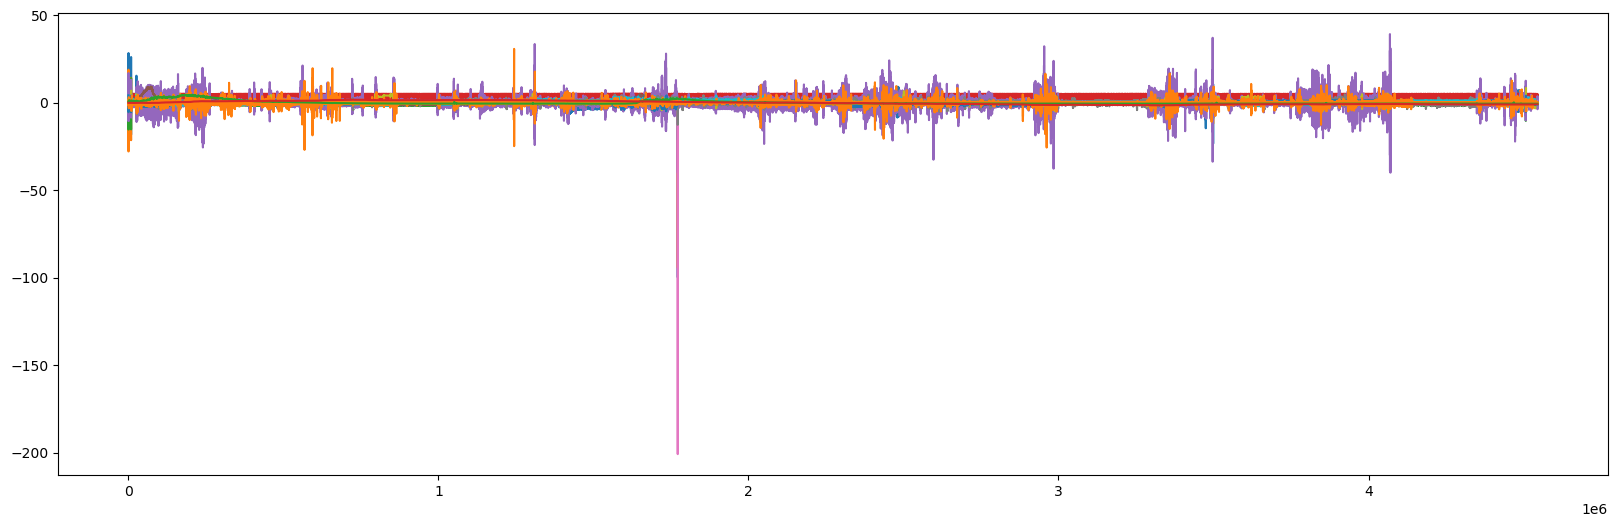

In [57]:
for ts in time_series:
    plt.plot(ts)
plt.show()


## Subsequence TS

In [4]:
start = 0
subsequences = []
subsequence_labels = []

while start+window_length < len(time_series[0]):
    subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])    
    subsequence = time_series[:,start:start+window_length]
    start = start+window_length - int(overlap_percent*window_length)
    subsequences.append(subsequence)

subsequences = np.asarray(subsequences)
subsequence_labels = np.asarray(subsequence_labels)
#batch_size = subsequences.shape[0]

C:\Users\Erik\AppData\Local\Temp\ipykernel_32544\1201957768.py:6: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


In [5]:
print(subsequences.shape)

(5410, 14, 1200)


## Set Data_loader for Neural Network?

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


data_loader = get_dataloader(data=subsequences,
                          shuffle=True,
                          batch_size=batch_size,
                          num_workers=1,
                          data_transforms=None)
torch.cuda.empty_cache()
input_shape = subsequences.shape
#torch.cuda.memory_summary(device=None, abbreviated=False)



cuda


In [7]:
ground_truth

array([ 246997, 1044997, 1075097, 1126197, 1570697, 2018697, 2234997,
       2281897, 3007797, 3289197, 3502697, 3765197, 3880697, 3927597,
       4072496, 4337097], dtype=int64)

In [9]:
inputs = torch.rand(14,1200)
print(inputs.shape)
mod =  nn.Conv1d(14, 14, 150, stride=2)
out = mod(inputs)
print(out.shape)

mod =  nn.Conv1d(14, 14, 100, stride=3)
out = mod(out)
print(out.shape)

mod =  nn.Conv1d(14, 14, 100, stride=3)
out = mod(out)
print(out.shape)


torch.Size([14, 1200])
torch.Size([14, 526])
torch.Size([14, 143])
torch.Size([14, 15])


In [8]:
layers = [150,100,100]
strides = [2,3,3]

## Create DC-TSS model

In [9]:
deep_cluster_model = DEC(n_clusters = n_clusters, input_shape=input_shape,k_sizes=layers,strides=strides)
deep_cluster_model.to(device)


DEC(
  (AE): Autoencoder(
    (encoder): Sequential(
      (0): Conv1d(14, 14, kernel_size=(150,), stride=(2,))
      (1): LeakyReLU(negative_slope=0.1)
      (2): Conv1d(14, 14, kernel_size=(100,), stride=(3,))
      (3): LeakyReLU(negative_slope=0.1)
      (4): Conv1d(14, 14, kernel_size=(100,), stride=(3,))
    )
    (decoder): Sequential(
      (0): ConvTranspose1d(14, 14, kernel_size=(100,), stride=(3,))
      (1): LeakyReLU(negative_slope=0.1)
      (2): ConvTranspose1d(14, 14, kernel_size=(100,), stride=(3,))
      (3): LeakyReLU(negative_slope=0.1)
      (4): ConvTranspose1d(14, 14, kernel_size=(150,), stride=(2,))
      (5): LeakyReLU(negative_slope=0.1)
      (6): Upsample(size=1200, mode=nearest)
    )
  )
  (clustlayer): clustering()
  (model): Sequential(
    (0): Sequential(
      (0): Conv1d(14, 14, kernel_size=(150,), stride=(2,))
      (1): LeakyReLU(negative_slope=0.1)
      (2): Conv1d(14, 14, kernel_size=(100,), stride=(3,))
      (3): LeakyReLU(negative_slope=0.1)


In [10]:
import time

## Phase 1: Initialize Latent Space Mapping with 1DCNN AE

In [11]:
pretraining(model=deep_cluster_model, dbgenerator=data_loader, batch_size=batch_size, epochs=epochs1)


epoch 1,loss = 0.93977469
epoch 2,loss = 0.86820966
epoch 3,loss = 0.85906786
epoch 4,loss = 0.75044161
epoch 5,loss = 0.76358122
epoch 6,loss = 0.73348725
epoch 7,loss = 1.92117667
epoch 8,loss = 0.69693506
epoch 9,loss = 0.65081775
epoch 10,loss = 0.69178009
epoch 11,loss = 0.56596833
epoch 12,loss = 0.63382494
epoch 13,loss = 0.64783502
epoch 14,loss = 0.62836164
epoch 15,loss = 0.65651643
epoch 16,loss = 0.65979779
epoch 17,loss = 0.60935193
epoch 18,loss = 1.77988195
epoch 19,loss = 0.62648726
epoch 20,loss = 0.59970737
epoch 21,loss = 0.61981285
epoch 22,loss = 0.55349284
epoch 23,loss = 0.60425562
epoch 24,loss = 0.56443542
epoch 25,loss = 1.42745864
epoch 26,loss = 1.29620039


KeyboardInterrupt: 

In [66]:
torch.save(deep_cluster_model.state_dict(), './wesad1_pretrain.pth')

In [11]:
deep_cluster_model = DEC(n_clusters = n_clusters, input_shape=input_shape,k_sizes=layers,strides=strides)
deep_cluster_model.load_state_dict(torch.load('./wesad1_pretrain.pth'))
deep_cluster_model.to(device)

DEC(
  (AE): Autoencoder(
    (encoder): Sequential(
      (0): Conv1d(14, 14, kernel_size=(150,), stride=(2,))
      (1): LeakyReLU(negative_slope=0.1)
      (2): Conv1d(14, 14, kernel_size=(100,), stride=(3,))
      (3): LeakyReLU(negative_slope=0.1)
      (4): Conv1d(14, 14, kernel_size=(100,), stride=(3,))
    )
    (decoder): Sequential(
      (0): ConvTranspose1d(14, 14, kernel_size=(100,), stride=(3,))
      (1): LeakyReLU(negative_slope=0.1)
      (2): ConvTranspose1d(14, 14, kernel_size=(100,), stride=(3,))
      (3): LeakyReLU(negative_slope=0.1)
      (4): ConvTranspose1d(14, 14, kernel_size=(150,), stride=(2,))
      (5): LeakyReLU(negative_slope=0.1)
      (6): Upsample(size=1200, mode=nearest)
    )
  )
  (clustlayer): clustering()
  (model): Sequential(
    (0): Sequential(
      (0): Conv1d(14, 14, kernel_size=(150,), stride=(2,))
      (1): LeakyReLU(negative_slope=0.1)
      (2): Conv1d(14, 14, kernel_size=(100,), stride=(3,))
      (3): LeakyReLU(negative_slope=0.1)


## Phase 2: Refine Latent Space and Find Clusters

In [12]:
cluster_assignments = refine_clusters(n_clusters, data_loader, deep_cluster_model, device, 4000, batch_size, lr, 0.0, 1)


Initializing cluster centers with k-means. number of clusters 60
torch.Size([5410, 14, 1200])
11.0
Epoch 200:   loss= 0.62707  cluster difference= 1.0
Epoch 400:   loss= 0.58454  cluster difference= 0.31164510166358594
Epoch 600:   loss= 0.56936  cluster difference= 0.3136783733826248
Epoch 800:   loss= 0.55185  cluster difference= 0.2691312384473198
Epoch 1000:   loss= 0.54377  cluster difference= 0.13401109057301294
Epoch 1200:   loss= 0.53585  cluster difference= 0.1813308687615527
Epoch 1400:   loss= 0.529  cluster difference= 0.16377079482439927
Epoch 1600:   loss= 0.52526  cluster difference= 0.19186691312384474
Epoch 1800:   loss= 0.52095  cluster difference= 0.122181146025878
Epoch 2000:   loss= 0.51673  cluster difference= 0.19297597042513864
Epoch 2200:   loss= 0.51362  cluster difference= 0.1844731977818854
Epoch 2400:   loss= 0.5121  cluster difference= 0.1988909426987061
Epoch 2600:   loss= 0.51088  cluster difference= 0.20573012939001847
Epoch 2800:   loss= 0.50811  clust

In [13]:
print(cluster_assignments)

[48 48 48 ... 42 42 42]


## Visualize Latent Space with t-SNE

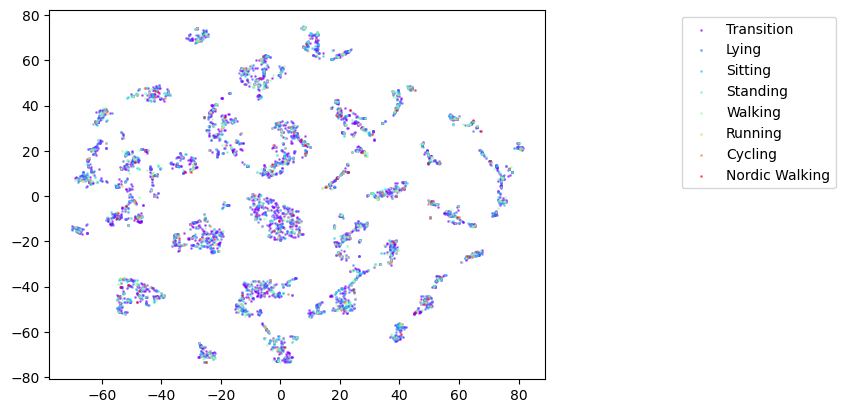

In [14]:
clustering_output = []
for ts in data_loader:
    recon = deep_cluster_model.AE.encode((ts.float().to(device)))
    clustering_output.append( recon.cpu().detach().numpy() ) 
    

clustering_output = [item for sublist in clustering_output for item in sublist]

clustering_output = np.asarray(clustering_output)
clustering_output_f = []
for i,co in enumerate(clustering_output):
    clustering_output[i].flatten()
    clustering_output_f.append(clustering_output[i].flatten())
clustering_output_f = np.asarray(clustering_output_f)

activities = []
activities.append(labels[0])
for l in labels:
    if l != activities[-1]:
        activities.append(int(l))


activity_names = ['Transition',
                  'Lying',
                  'Sitting',
                  'Standing',
                  'Walking',
                  'Running',
                  'Cycling',
                  'Nordic Walking',
                  '8',
                  'Watching TV',
                  'Computer Work',
                  'Car Driving',
                  'Ascending Stairs',
                  'Descending Stairs',
                  '14',
                  '15',
                  'Vacuum Cleaning',
                  'Ironing',
                  'Folding Laundry',
                  'House Cleaning',
                  'Playing Soccer',
                  '21',
                  '22',
                  '23',
                  'Rope Jumping']

X_embedded = TSNE(n_components=2).fit_transform(clustering_output_f)

cmap = plt.get_cmap('rainbow')

l = np.unique(labels)
slicedCM = cmap(np.linspace(0, 1, len(l))) 



for m,la in enumerate(l): 
    ind = np.where(subsequence_labels==la)
    plt.scatter(X_embedded[ind,0],X_embedded[ind,1],color=slicedCM[m], label=activity_names[int(la)], alpha=0.5, s=1)

plt.legend(loc=1, bbox_to_anchor=(1.1, 0., 0.5, 1.0))

## Remove Duplicate Cluster Labels and Set Labels in Sequential Order

In [15]:
while ( (not all(l[i] == l[i+1] -1 for i in range(len(l) - 1))) or (l[0] != 0) ):
    for assignment in range(np.max(cluster_assignments)+1):
        if assignment not in cluster_assignments:
            indx = np.where(cluster_assignments > assignment)
            cluster_assignments[indx] = cluster_assignments[indx]-1
    l = np.unique(cluster_assignments)

## Phase 3: Sldiing Window on Cluster Labels

In [38]:
window_length2 = 250

similarities = get_label_score(cluster_assignments, window_length2)


## Normalize and Smooth Sliding Window Distance

In [39]:
data = (similarities - np.min(similarities)) / (np.max(similarities) - np.min(similarities))
data = smooth(np.blackman(75), data)

In [40]:
peaks, peak_data = find_peaks(data, height=0.75,distance=window_length2//1,prominence=0.2)
real_peaks = peaks+window_length2//2
predictions = get_changepoints(real_peaks, window_length, overlap_percent)


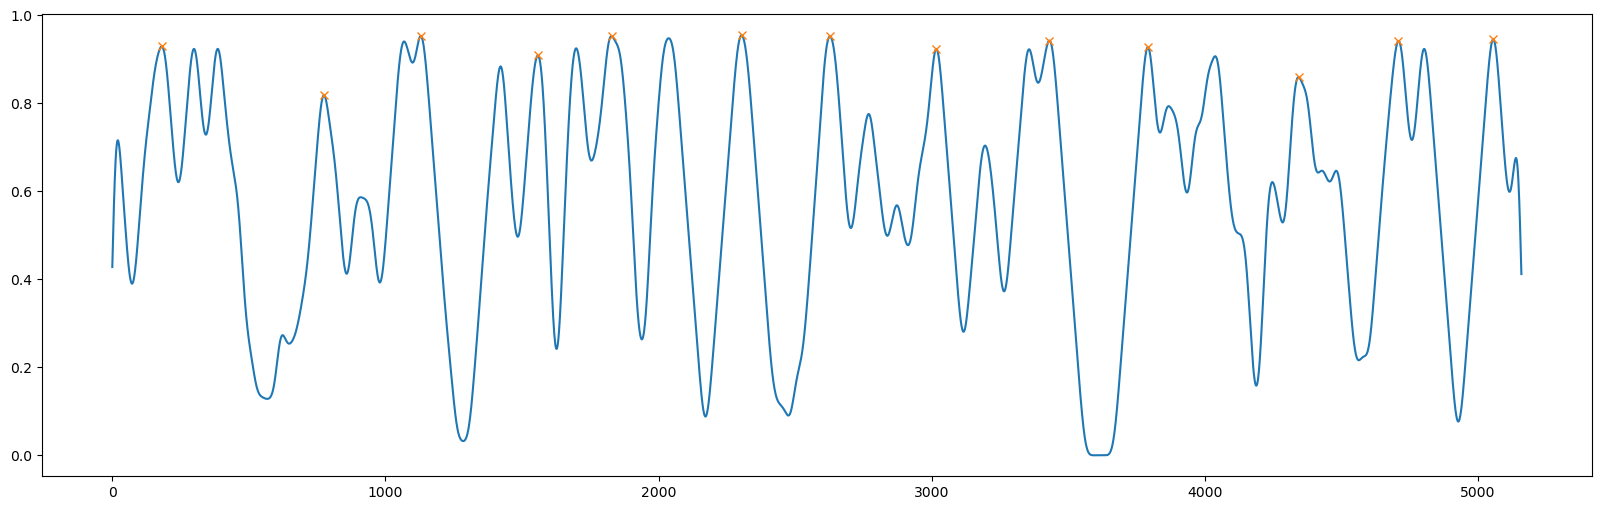

[ 306  900 1254 1683 1953 2429 2753 3142 3556 3916 4468 4834 5181]
Space: Encoded Hidden Space
Clusters = 60


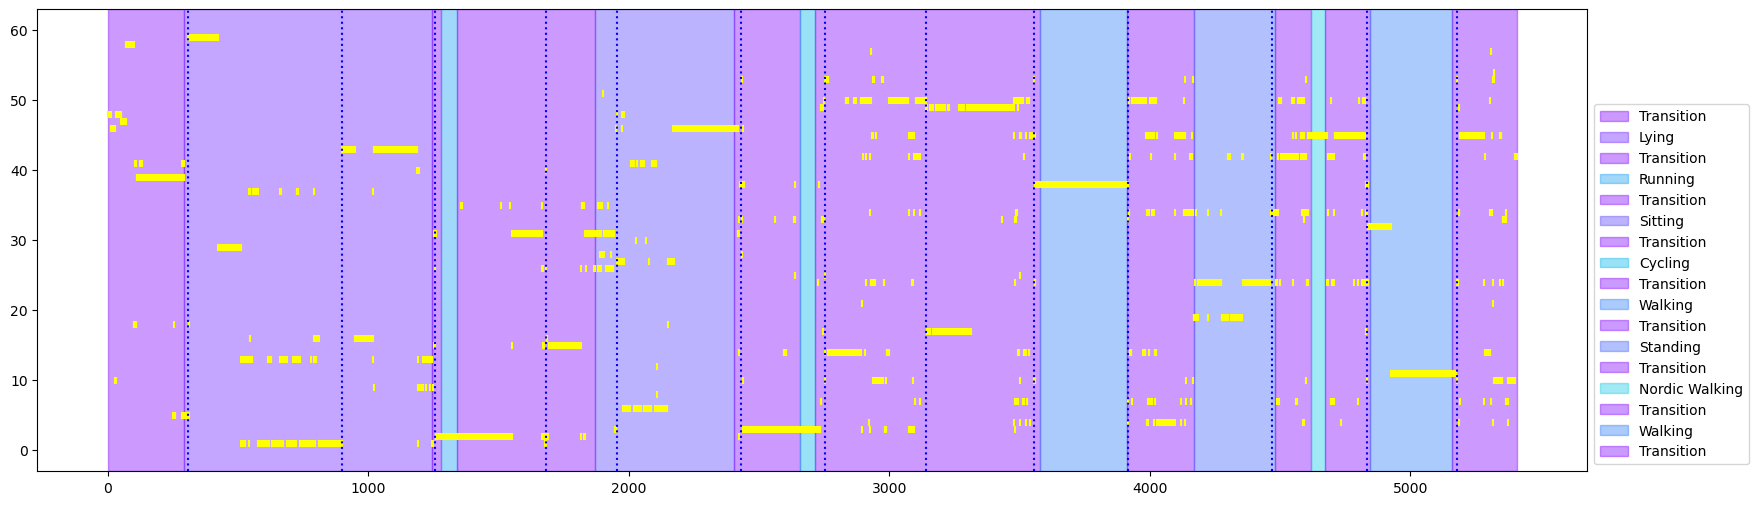

covering score: 0.636477704507911
margin: 21000
f_measure score: (0.5161290322580646, 0.5714285714285714, 0.47058823529411764)


In [41]:
plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')
cmap = plt.get_cmap('rainbow')

l = np.unique(labels)


slicedCM = cmap(np.linspace(0, 1, len(activity_names))) 


plt.plot(data)
plt.plot(peaks, data[peaks], "x")
plt.show()

positions = np.arange(len(cluster_assignments))[:,np.newaxis]

plt.eventplot(positions, lineoffsets=cluster_assignments, color = [(1.0,1.0,0.0)])
print(real_peaks)
for vline in real_peaks:
    plt.axvline(x = vline, color = 'b', linestyle=':', mfc='b')

start = 0
subsequence_ground_truth = np.where(subsequence_labels[:-1] != subsequence_labels[1:])[0]
print("Space: Encoded Hidden Space\nClusters = {}".format(n_clusters))
for i, activity in enumerate(activities):
    if i == len(activities):
        continue
    if i == len(activities)-1:
        end = len(subsequence_labels)
    else:
        end = subsequence_ground_truth[i]

    plt.axvspan(start, end, alpha=0.4, color=slicedCM[int(activity)], label=activity_names[int(activity)])
    plt.legend(loc=3, bbox_to_anchor=(1, 0, 0, 1.0))
    start = end
plt.show()

print('covering score:',covering(ground_truth, predictions, len(labels)))
margin = 700*30
print('margin:',margin)
print('f_measure score:',f_measure(ground_truth, predictions, margin=margin, alpha=0.5, return_PR=True))

In [45]:
len(labels)

376417

In [65]:
covering(ground_truth, ground_truth[6:]+1000, len(labels))

0.6505954620925285

In [158]:
len(ground_truth)

25

In [159]:
len(predictions)

35

In [160]:
predictions

[5120,
 14416,
 19344,
 29872,
 34352,
 40176,
 56864,
 72096,
 77136,
 85872,
 107600,
 115888,
 119584,
 124736,
 140976,
 147808,
 151840,
 161808,
 167632,
 174240,
 179840,
 184768,
 198880,
 204368,
 215008,
 221504,
 245136,
 254656,
 272352,
 284000,
 306176,
 313792,
 335744,
 350192,
 362176]